# Multiclass Adam (and SGD) on a general problem class

#### Notes
 
 - I super recommend using a GPU to run this, otherwise it's slow.
 - Code currently can't handle a non-diagonal data covariance for Adam. The "gradient noise term" isn't calculated correctly (It gets much more expensive). TODO
 - If Adam looks bad increase the "history_length" and "num_samples" values in the "compute_phi..." and "compute_cov.." functions. These control and approximation quality

100%|██████████| 300/300 [03:32<00:00,  1.41it/s]


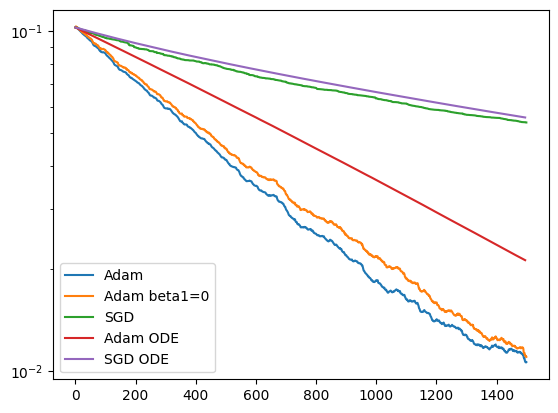

In [1]:
from optimizers import Adam, SGD
from sdes import AdamSDE, SgdSDE
from odes import AdamODE, SgdODE

import jax
import jax.numpy as jnp
from jax.numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
import scipy
# Setup the problem and parameters
problem_type = 'linreg' # from  'logreg' or 'linreg', 'real_phase_ret'

d = 500 # dimension
m = 1 # number of classes (target dimension)
beta1 = 0.4 
beta2 = 0.5
T = 3 # time to run SDE for

lr = 0.9 # SDE learning rate
lrk = lr / d # Optimzer learning rate

# lr = lambda x: jnp.cos(2 * x / T) # SDE learning rate
# lrk = lambda x: jnp.cos(2 * x / T / d) / d # Optimizer learning rate

# cov = jnp.linspace(0.1, 1, d) # initialize with diagonal covariance
cov = jnp.array([j**(-0.5) for j in range(1, d+1)])

# cov = jnp.ones(d)
# U = scipy.stats.ortho_group.rvs(d)
# cov = U @ jnp.diag(cov) @ U.T

key = jax.random.PRNGKey(np.random.randint(0, 10000))
key_init, key_opt, key = jax.random.split(key, 3)

params0 = jax.random.normal(key_init, (d,m))
optimal_params = jax.random.normal(key_opt, (d,m))

params0 /= norm(params0, axis = 0)
# params0 *= 1
optimal_params /= norm(optimal_params, axis = 0)

# Run the optimizers
adam = Adam(problem_type)
sgd = SGD(problem_type)

_, sgd_risks = sgd.run(params0, cov, T, lrk, optimal_params)
_, adam_risks = adam.run(params0, cov, T, lrk, optimal_params, beta1 = beta1, beta2 = beta2, eps = 0.00)
_, adam_risks_beta0 = adam.run(params0, cov, T, lrk, optimal_params, beta1 = 0, beta2 = beta2, eps = 0.00)

# Run the SDE equivalents
sgd_sde = SgdSDE(problem_type)
adam_sde = AdamSDE(problem_type)

# _, sgd_sde_risks, times_s = sgd_sde.run(params0, optimal_params, cov, T, lr)
# params, adam_sde_risks, times_s = adam_sde.run(params0, optimal_params, cov, T, lr, beta1 = beta1, beta2 = beta2)

# Run the ODE equivalents
adam_ode = AdamODE(problem_type)
sgd_ode = SgdODE(problem_type)

sgd_risk, time, B = sgd_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01)
adam_risk, time, B = adam_ode.run(params0, optimal_params, cov, T, lr, dt = 0.01, beta1 = beta1, beta2 = beta2, eps = 0.001)

plt.yscale('log')
# plt.xscale('log')
plt.plot(adam_risks, label = 'Adam')
plt.plot(adam_risks_beta0, label = 'Adam beta1=0')
plt.plot(sgd_risks, label = 'SGD')

# plt.plot(times_s * d, adam_sde_risks, label = 'Adam SDE')
# plt.plot(times_s * d, sgd_sde_risks, label = 'SGD SDE')

plt.plot(time * d, adam_risk, label = 'Adam ODE')
plt.plot(time * d, sgd_risk, label = 'SGD ODE')

plt.legend()
plt.show()